# Notebook to showcase classification

In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import json
from joblib import dump, load

from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import xgboost as xgb

from tsfresh.transformers import RelevantFeatureAugmenter
# from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters #, MinimalFCParameters

from eis_tsfresh_xgb import create_pipeline_clf

from eis_preprocessing import preprocess_data
from eis_preprocessing import unwrap_df

from utils import plot_cm
from utils import shap_feature_analysis

/Users/joachim/opt/anaconda3/envs/eis-battmen/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
d_path = "data/"
m_path = "models/xgb/"
verbose = 0
save_model = 0 
shap_analysis = 0

# Another way of training for experimental purposes, switch on by setting this variable to 1
multiclass_selection_features = 0 

In [3]:
df = preprocess_data(d_path + "train_data.csv")

# For tsfresh we need to 'unwrap' all the measurements into a dataframe with measurement ids, freq, zreal, and zimag columns
df_ts = unwrap_df(df)

if verbose:
    print(df_ts.shape, len(np.unique(df_ts["id"])))
    print(df_ts.head)

In [4]:
# Creating labels y
df_x = pd.DataFrame(index=np.unique(df_ts["id"]))
le = LabelEncoder()
df_y = pd.Series(data=(le.fit_transform(df["Circuit"])), index=np.unique(df_ts["id"]))

## Section with train test spplit taking only data that was availble to the participants

In [5]:
# The data is splitted here for development purposes, because the labeled test data was not available to the participants during the hackathon
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

In [6]:
ppl = create_pipeline_clf(df_ts)
ppl.fit(X_train, y_train)

Feature Extraction: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it]
/Users/joachim/opt/anaconda3/envs/eis-battmen/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:202: RuntimeWarning: The columns ['zreal__fft_coefficient__attr_"real"__coeff_16'
 'zreal__fft_coefficient__attr_"real"__coeff_17'
 'zreal__fft_coefficient__attr_"real"__coeff_18'
 'zreal__fft_coefficient__attr_"real"__coeff_19'
 'zreal__fft_coefficient__attr_"real"__coeff_20'
 'zreal__fft_coefficient__attr_"real"__coeff_21'
 'zreal__fft_coefficient__attr_"real"__coeff_22'
 'zreal__fft_coefficient__attr_"real"__coeff_23'
 'zreal__fft_coefficient__attr_"real"__coeff_24'
 'zreal__fft_coefficient__attr_"real"__coeff_25'
 'zreal__fft_coefficient__attr_"real"__coeff_26'
 'zreal__fft_coefficient__attr_"real"__coeff_27'
 'zreal__fft_coefficient__attr_"real"__coeff_28'
 'zreal__fft_coefficient__attr_"real"__coeff_29'
 'zreal__fft_coefficient__attr_"real"__coeff_30'
 'zreal__fft_coefficient__attr_"real"__coeff_31'


[10:58:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('augmenter',
                 RelevantFeatureAugmenter(column_id='id', column_sort='freq',
                                          default_fc_parameters={'abs_energy': None,
                                                                 'absolute_maximum': None,
                                                                 'absolute_sum_of_changes': None,
                                                                 'agg_autocorrelation': [{'f_agg': 'mean',
                                                                                          'maxlag': 40},
                                                                                         {'f_agg': 'median',
                                                                                          'maxlag': 40},
                                                                                         {'f_agg': 'var',
                                                                                      

Feature Extraction: 100%|██████████| 25/25 [01:16<00:00,  3.05s/it]


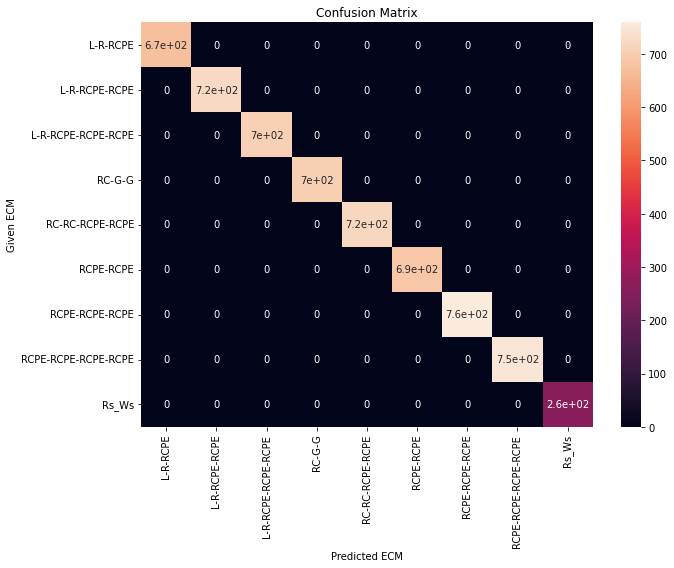

Train Accuracy: 1.0


In [7]:
y_train_pred = ppl.predict(X_train)
# print(classification_report(y_train, y_train_pred))
plot_cm(y_train, y_train_pred, le, save=0)

proportion_correct = accuracy_score(y_train, y_train_pred)
print('Train Accuracy: {}'.format(proportion_correct))

Feature Extraction: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


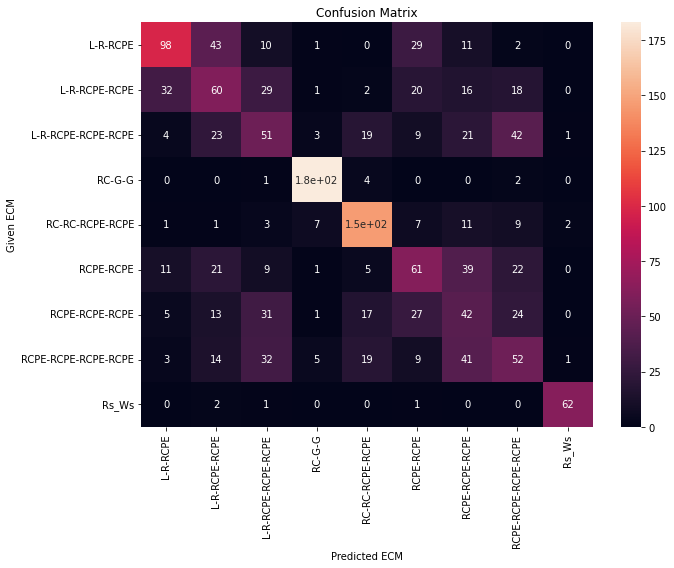

Test Accuracy: 0.5056932350971199


In [8]:
y_test_pred = ppl.predict(X_test)
# print(classification_report(y_test, y_test_pred))
plot_cm(y_test, y_test_pred, le, save=0)

proportion_correct = accuracy_score(y_test, y_test_pred)
print('Test Accuracy: {}'.format(proportion_correct))

In [9]:
# Display relevant features
# ppl.named_steps["augmenter"].feature_selector.relevant_features

In [10]:
if shap_analysis:
    shap_feature_analysis(ppl, X_test, le)

# Train using all data that was available to the participants and test on held out dataset

In [11]:
# X contains just id's, this is due to the way ts fresh has to be set up with pipelines. 
X_train_full = df_x
y_train_full = df_y

In [12]:
ppl_all = create_pipeline_clf(df_ts)
ppl_all.fit(X_train_full, y_train_full)

Feature Extraction: 100%|██████████| 25/25 [01:40<00:00,  4.01s/it]
/Users/joachim/opt/anaconda3/envs/eis-battmen/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:202: RuntimeWarning: The columns ['zreal__fft_coefficient__attr_"real"__coeff_16'
 'zreal__fft_coefficient__attr_"real"__coeff_17'
 'zreal__fft_coefficient__attr_"real"__coeff_18'
 'zreal__fft_coefficient__attr_"real"__coeff_19'
 'zreal__fft_coefficient__attr_"real"__coeff_20'
 'zreal__fft_coefficient__attr_"real"__coeff_21'
 'zreal__fft_coefficient__attr_"real"__coeff_22'
 'zreal__fft_coefficient__attr_"real"__coeff_23'
 'zreal__fft_coefficient__attr_"real"__coeff_24'
 'zreal__fft_coefficient__attr_"real"__coeff_25'
 'zreal__fft_coefficient__attr_"real"__coeff_26'
 'zreal__fft_coefficient__attr_"real"__coeff_27'
 'zreal__fft_coefficient__attr_"real"__coeff_28'
 'zreal__fft_coefficient__attr_"real"__coeff_29'
 'zreal__fft_coefficient__attr_"real"__coeff_30'
 'zreal__fft_coefficient__attr_"real"__coeff_31'


[11:03:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('augmenter',
                 RelevantFeatureAugmenter(column_id='id', column_sort='freq',
                                          default_fc_parameters={'abs_energy': None,
                                                                 'absolute_maximum': None,
                                                                 'absolute_sum_of_changes': None,
                                                                 'agg_autocorrelation': [{'f_agg': 'mean',
                                                                                          'maxlag': 40},
                                                                                         {'f_agg': 'median',
                                                                                          'maxlag': 40},
                                                                                         {'f_agg': 'var',
                                                                                      

In [13]:
# ppl_all.named_steps["augmenter"].feature_selector.relevant_features

Feature Extraction: 100%|██████████| 25/25 [01:34<00:00,  3.76s/it]


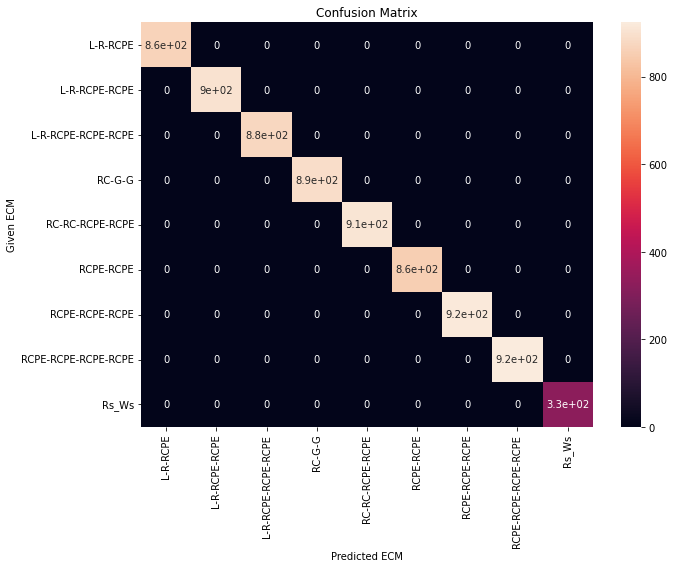

Train Accuracy: 1.0


In [14]:
y_train_pred = ppl_all.predict(X_train_full)
# print(classification_report(y_train, y_train_pred))
plot_cm(y_train_full, y_train_pred, le, save=0)

proportion_correct = accuracy_score(y_train_full, y_train_pred)
print('Train Accuracy: {}'.format(proportion_correct))

Feature Extraction: 100%|██████████| 25/25 [00:29<00:00,  1.20s/it]


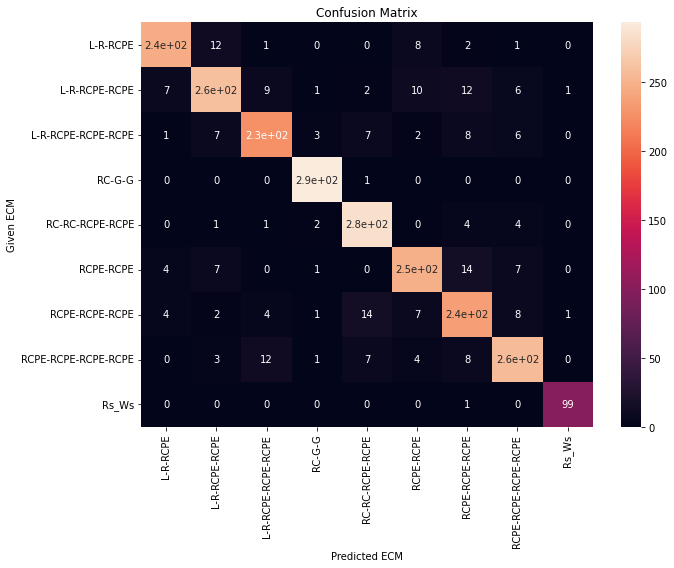

Test Accuracy: 0.903578947368421


In [15]:
# Now lets process to the test data.

df_test = preprocess_data(d_path + "test_data_hold_out_labeled.csv")
df_ts_test = unwrap_df(df_test)

# If label encodes is not availble (e.g. this script is separated, uncommenitng the folling lines allows to restore the same encoder that encoded the training data)
# with open(f"{m_path}labels.json", "r") as f:
#    label_dict = json.load(f)
# le = LabelEncoder()
# classes = np.array([label_dict[str(i)] for i in range(9)])
# le.classes_ = classes

X_test_full = pd.DataFrame(index=np.unique(df_ts_test["id"]))
y_test_full = pd.Series(data=(le.fit_transform(df_test["Circuit"])), index=np.unique(df_ts_test["id"]))

# Important step to pass the test data X to the pipeline. Important: df_ts_test does not coantin any labels y!
ppl_all.set_params(augmenter__timeseries_container=df_ts_test);
y_test_pred = ppl_all.predict(X_test_full)

# print(classification_report(y_test, y_test_pred))
plot_cm(y_test_full, y_test_pred, le, save=0)

proportion_correct = accuracy_score(y_test_full, y_test_pred)
print('Test Accuracy: {}'.format(proportion_correct))

In [16]:
if save_model:
    dump(ppl, 'xgb-ts-feat-clf-train-data-pipeline.joblib') 
    dump(ppl_all, 'xgb-ts-feat-clf-all-data-pipeline.joblib') 

# ppl = load("xgb-ts-feat-clf-all-data-pipeline.joblib")

We can also add in other features, or the interpolated raw data as before.

"In this example we passed in an empty (except the index) `X_train` or `X_test` into the pipeline. However, you can also fill the input with other features you have (e.g. features extracted from the metadata) or even use other pipeline components before."

So we just need to construct X as our previous examples but also include the id column.

### Multiclass selection features - just another way to do it (hint, this is worse).

In [17]:
if multiclass_selection_features:
    from tsfresh import extract_features, select_features
    X = extract_features(df_ts, column_id="id", column_sort="freq", impute_function=impute)
    X_train, X_test, y_train, y_test = train_test_split(X, df_y)
    X_train_filtered_multi = select_features(X_train, y_train, multiclass=True, n_significant=9)
    X_test_filtered_multi = X_test[X_train_filtered_multi.columns]

    #gbm = xgb.XGBClassifier().fit(X_train_filtered_multi, y_train)
    gbm = xgb.XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.05).fit(X_train_filtered_multi, y_train)

    y_pred = gbm.predict(X_test_filtered_multi)
    print(classification_report(y_test, y_pred))

    proportion_correct = accuracy_score(y_test, y_pred)
    print('Test Accuracy: {}'.format(proportion_correct))

    plot_cm(y_test, y_pred, le, save=0)